# Winequality dataset

## Feim els imports

In [1]:
#IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression, RFE

from feature_engine.creation import MathematicalCombination, CombineWithReferenceFeature

## Preparam el dataset

Funció que separa les features i les etiquetes, escalant les dades

In [2]:
def load_data(df):
    y=df.quality
    X=df.drop('quality',axis=1)
    X = min_max_scaler.fit_transform(X)
    return X, y

Carregam els datasets a dos dataframes a partir dels fitxers csv: winequality-red.csv i winequality-white.csv

Afegim una nova columna que indiqui el tipus de vi a cada dataset i juntam els dos datasets en un de nou

In [3]:
#CREATE AND MERGE DATAFRAMES
dfRed=pd.read_csv("winequality-red.csv", sep=";")
dfWhite=pd.read_csv("winequality-white.csv", sep=";")

dfRed['type']="Red"
dfWhite['type']="White"
df = pd.concat([dfRed,dfWhite])

Consultam les files del dataframe amb valors absents i les eliminam

In [4]:
df[df.isna().any(axis=1)]
df.dropna(inplace=True)

Convertim els valors categòrics en númerics

In [5]:
labelencoder = preprocessing.LabelEncoder()

df['type']=labelencoder.fit_transform(df['type'])

Recolocam les columnes

In [6]:
df = df.reindex(columns=['fixed acidity', 'volatile acidity', 'citric acid', 
                       'residual sugar', 'chlorides', 'free sulfur dioxide',
                       'total sulfur dioxide', 'density', 'pH', 'sulphates', 
                       'alcohol', 'type', 'quality'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  type                  6497 non-null   int32  
 12  quality               6497 non-null   int64  
dtypes: float64(11), int32(1), int64(1)
memory usage: 685.2 KB


In [8]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,5


Mesclam el dataframe i carregam les dades a les variables *features* (característiques) i *labels* (etiquetes)

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
df = df.sample(frac=1)

features, labels = load_data(df)

### Separació del conjunt d'entrenament i el de test
Per separar les dades en els conjunts d'entrenament i de test hem emprat la funció train_test_split

Hem decidit emprar un 80% entrenament i un 20% de test ja que  amb un valor més baix d'entrenament el model de regressió logistica i el del perceptró presentaven underfiting 


In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Visualització de les dades

Aquí podem observar les correlacions entre els distints atributs

<AxesSubplot:>

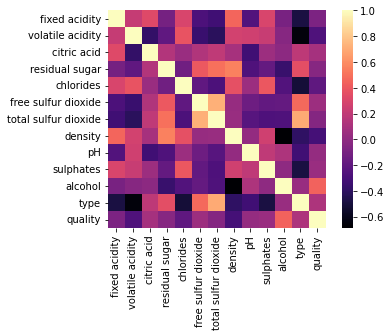

In [11]:
corr = df.corr() #Abs?

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        square=True,
        cmap="magma")

Graficam el valor que prenen les característiques númeriques del dataframe mitjançant un histograma

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

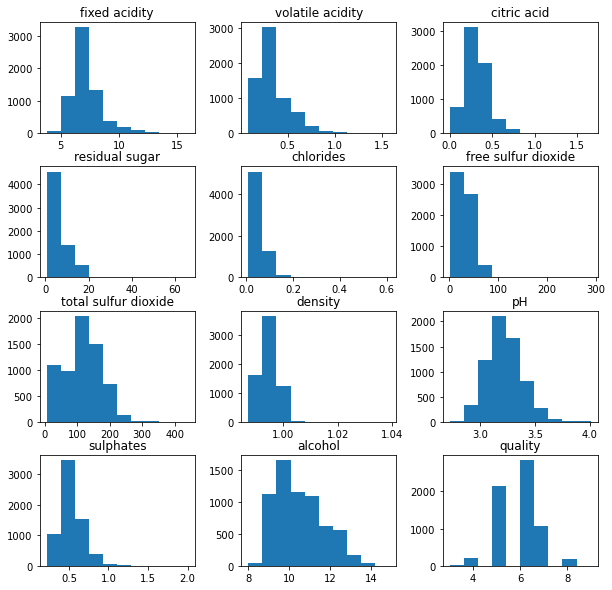

In [12]:
df.drop("type", axis=1).hist(figsize=(10,10), grid=False)

Gràfic cirular amb el que podem veure la proporció de vi blanc i vermell

1    75.388641
0    24.611359
Name: type, dtype: float64


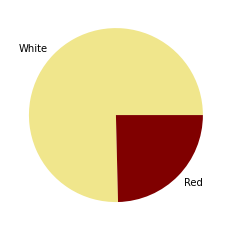

In [13]:
plt.pie(df['type'].value_counts(), labels = ["White","Red"], colors=["khaki","Maroon"])
print(df['type'].value_counts(normalize=True)*100)

# **Classificadors**

Per a cada model imprimim el seu classification report, la precisió de training i la de testing. A més, guardam aquests dos valors dins dos dataframes externs per a després poder comparar les modificacions que farem al dataframe original

Hem decidit fer els models dins funcions per poder cridar-les des de l'apartat de [Enginyeria de característiques/Proves](#Proves) fora haver de reescriure el codi.

In [14]:
dfTrain = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])
dfTest = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])

## Regressió Logística

Hem decidit donar-li valor al hiperparàmetre max_iters perquè amb el valor per defecte no arribava a convergir.

In [15]:
def RegressioLogisitca(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    logreg = LogisticRegression(max_iter=5000)
    logreg.fit(X_train,y_train)

    y_predict = logreg.predict(X_test)

    print("\nRegressio Logísitca:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = logreg.score(X_train,y_train)
    print('training_accuracy:',training_accuracy*100)

    testing_accuracy = logreg.score(X_test,y_test)
    print('testing_accuracy:',testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrain.at[nom,'Regressió Logística']=training_accuracy*100
    dfTest.at[nom,'Regressió Logística']=testing_accuracy*100 
RegressioLogisitca(df, "Original")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.59      0.60      0.60       424
           6       0.51      0.74      0.60       563
           7       0.53      0.15      0.23       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.81      0.22      0.21      1300
weighted avg       0.57      0.54      0.50      1300

training_accuracy: 53.99268808928228
testing_accuracy: 54.07692307692308


## Perceptró

In [16]:
def Perceptro(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    perceptron = Perceptron()
    perceptron.fit(X_train, y_train)

    y_predict=perceptron.predict(X_test)

    print("\nPerceptró:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = perceptron.score(X_train,y_train)
    print('training_accuracy:',training_accuracy*100)

    testing_accuracy = perceptron.score(X_test,y_test)
    print('testing_accuracy:',testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrain.at[nom,'Perceptró']=training_accuracy*100
    dfTest.at[nom,'Perceptró']=testing_accuracy*100     
Perceptro(df, "Original")


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.00      0.00        39
           5       0.60      0.44      0.50       424
           6       0.47      0.83      0.60       563
           7       0.00      0.00      0.00       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.50      1300
   macro avg       0.72      0.18      0.16      1300
weighted avg       0.47      0.50      0.42      1300

training_accuracy: 50.70232826630748
testing_accuracy: 50.0


## Random Forest

Hem decidit donar-li valor al hiperparàmetre max_depth perquè amb el valor per defecte teniem overfitting.

In [17]:
def RandomForest(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    rf = RandomForestClassifier(max_depth=14)
    rf.fit(X_train, y_train)

    y_predict=rf.predict(X_test)

    print("\nRandom Forest:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = rf.score(X_train,y_train)
    print('training_accuracy:',training_accuracy*100)

    testing_accuracy = rf.score(X_test,y_test)
    print('testing_accuracy:',testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrain.at[nom,'Random Forest']=training_accuracy*100
    dfTest.at[nom,'Random Forest']=testing_accuracy*100         
RandomForest(df, "Original")


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       0.60      0.08      0.14        39
           5       0.75      0.72      0.74       424
           6       0.66      0.83      0.73       563
           7       0.75      0.54      0.62       226
           8       0.83      0.36      0.50        42
           9       1.00      0.00      0.00         1

    accuracy                           0.70      1300
   macro avg       0.80      0.36      0.39      1300
weighted avg       0.71      0.70      0.69      1300

training_accuracy: 97.92187800654224
testing_accuracy: 70.07692307692308


## Conclusions


Blablabla

# **Enginyeria de característiques**

L'enginyeria de característiques (feature engineering) és el procés de selecció, extracció, creació i transformació de les característiques d'un dataset amb l'objectiu de millorar l'eficacia d'un model predictiu.

Per a dur a terme l'enginyeria de característiques nosaltres hem duit a terme els següents apartats: 
- **Feature importances dels models**: Ens permet saber la importancia de cada característica dins cada model amb el fi de després eliminar les característiques menys importants
- **Correlacions màximes i mínimes**: Ens permet saber quines caracterísitiques tenen major correlació entre elles. També ens permet saber quines caracteístiques tenen menys correlació amb la qualitat del vi per després poder eliminarles
- **Feature Selection**: Selecció de les característiques més i menys importantes. Nosaltres implementarem els:
   1. Sequential Feature Selection
   2. Univariate Feature Selection amb Kbest
   3. Recursive Feature Elimination

## Feature importances de cada model

In [18]:
dfWquality=df.drop("quality", axis=1)

### Regressió logística <a id='Regressio-Logistica'></a>

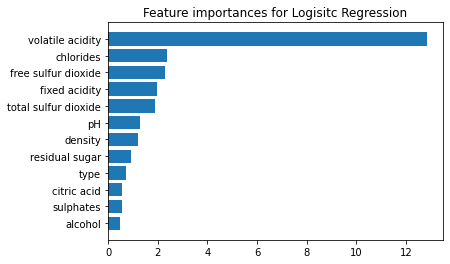

In [19]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train,y_train)

logreg_odds = np.exp(logreg.coef_[0])
indices=np.argsort(logreg_odds)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Logisitc Regression")
ax.barh(range(len(logreg_odds)), logreg_odds[indices])
ax.set_yticks(range(len(logreg_odds)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

### Perceptró <a id='Perceptro'></a>

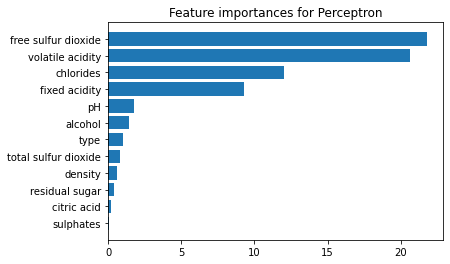

In [20]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

perceptron_odds = np.exp(perceptron.coef_[0])
indices=np.argsort(perceptron_odds)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Perceptron")
ax.barh(range(len(perceptron_odds)), perceptron_odds[indices])
ax.set_yticks(range(len(perceptron_odds)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

### Random Forest <a id='Random-Forest'></a>

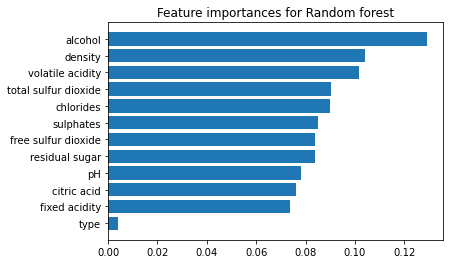

In [21]:
rf = RandomForestClassifier(max_depth=14)
rf.fit(X_train, y_train)

importancesRF = rf.feature_importances_
indices = np.argsort(importancesRF)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Random forest")
ax.barh(range(len(importancesRF)), importancesRF[indices])
ax.set_yticks(range(len(importancesRF)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

### 
| Model | Millor característica | Pitjor característica |
| ----------- | ----------- | ----------- |
| Regressió Logística | Volatile Acidity | Alcohol |
| Perceptró | Free Sulphure Dioxide | Sulphates |
| Random Forest | Alcohol | Type |

És curiós que la pitjor característica de la regressió logística sigui la millor del Random forest

Els resultats poden variar depenent de la execució, aquests valors son els obtinguts a una execució

## Correlacions màximes i mínimes <a id='Correlacions-Minimes'></a>

In [22]:
c = df.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

print(so[13:23]) #Les 12 primeres son autocorrelacions
print("-------------")
print(so['quality'][8:13])


free sulfur dioxide   total sulfur dioxide    0.720934
total sulfur dioxide  free sulfur dioxide     0.720934
type                  total sulfur dioxide    0.700357
total sulfur dioxide  type                    0.700357
density               alcohol                 0.686745
alcohol               density                 0.686745
volatile acidity      type                    0.653036
type                  volatile acidity        0.653036
residual sugar        density                 0.552517
density               residual sugar          0.552517
dtype: float64
-------------
free sulfur dioxide     0.055463
total sulfur dioxide    0.041385
sulphates               0.038485
residual sugar          0.036980
pH                      0.019506
dtype: float64


Les característiques amb major correlació son el *Free sulfur dioxide* i el *Total sulfur dioxide*\
Les característiques amb menor correlació amb la qualitat son el *pH*, *residual sugars* i *sulphates*

## [Feature Selection](https://www.scikit-learn.org/stable/modules/feature_selection.html)

### [Sequential Feature Selector](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py) <a id='Sequential-Feature-Selector'></a>


In [23]:
feature_names = np.array(dfWquality.columns)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)

In [24]:
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=10, direction="forward"
).fit(X_train, y_train)


sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=10, direction="backward"
).fit(X_train, y_train)


print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
    "\nFeatures not selected by forward sequential selection: "
    f"{dfWquality.columns.difference(feature_names[sfs_forward.get_support()])}\n"
)

print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
    "\nFeatures not selected by forward sequential selection: "
    f"{dfWquality.columns.difference(feature_names[sfs_backward.get_support()])}"
)

Features selected by forward sequential selection: ['fixed acidity' 'volatile acidity' 'residual sugar' 'chlorides'
 'free sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol' 'type']
Features not selected by forward sequential selection: Index(['citric acid', 'total sulfur dioxide'], dtype='object')

Features selected by backward sequential selection: ['fixed acidity' 'volatile acidity' 'residual sugar' 'free sulfur dioxide'
 'total sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol' 'type']
Features not selected by forward sequential selection: Index(['chlorides', 'citric acid'], dtype='object')


### [Univariate Feature selection with Kbest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html#sklearn.feature_selection.GenericUnivariateSelect) <a id='Univariate-feature-selection'></a> 


In [25]:
mask = SelectKBest(f_regression, k=10).fit(X_train, y_train).get_support()
best_features = dfWquality.columns[mask]
worst_features = dfWquality.columns.difference(best_features)
print("Best features", best_features)
print("Worst features", worst_features)


Best features Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'alcohol', 'type'],
      dtype='object')
Worst features Index(['pH', 'sulphates'], dtype='object')


### [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) <a id='Recursive-feature-elimination'></a> 


In [26]:
feature_names = np.array(dfWquality.columns)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)

In [27]:
rfe_selector = RFE(ridge, n_features_to_select=10).fit(X_train, y_train)

print(
    "Features selected by recursive feature elimination: "
    f"{feature_names[rfe_selector.get_support()]}"
    "\nFeatures not selected by recursive feature elimination: "
    f"{dfWquality.columns.difference(feature_names[rfe_selector.get_support()])}\n"
)

Features selected by recursive feature elimination: ['fixed acidity' 'volatile acidity' 'residual sugar' 'chlorides'
 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH' 'sulphates'
 'alcohol']
Features not selected by recursive feature elimination: Index(['citric acid', 'type'], dtype='object')



### 
| Tipus | 1ra Pitjor Caract. | 2na Pitjor Caract.|
| ----------- | ----------- | ----------- |
| Sequential Feature Selection - Forward| Free sulfur dioxide | Total sulfur dioxide |
| Sequential Feature Selection - backward| Chloride | Citric Acid |
| Univariate Feature Selection | pH | Sulphates |
| Recursive Feature Elimination | Citric Acid | Type |

## Proves <a id='Proves'></a>

### Eliminam features

#### Fora alcohol

Provam de llevar la característica de l'*alcohol* ja que com hem vist [aquí](#Regressio-Logistica), el Feature Selection de la Regressio Logístic ens diu que és la característica amb menys importancia

In [28]:
dfWalcohol = df.drop('alcohol',axis=1)

RegressioLogisitca(dfWalcohol, "Fora alcohol")
Perceptro(dfWalcohol, "Fora alcohol")
RandomForest(dfWalcohol, "Fora alcohol")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.56      0.47      0.51       424
           6       0.48      0.80      0.60       563
           7       0.00      0.00      0.00       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.50      1300
   macro avg       0.72      0.18      0.17      1300
weighted avg       0.46      0.50      0.43      1300

training_accuracy: 51.14489128343275
testing_accuracy: 50.0

Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       0.27      0.10      0.15        39
           5       0.54      0.52      0.53       424
           6       0.48      0.66      0.56       563
           7       0.43      0.18     

#### Fora sulphates

Provam de llevar la característica de sulphates ja que com hem vist [aquí](#Perceptro), el Feature Selection del Perceptro ens diu que és la característica amb menys importancia

In [29]:
dfWsulphates = df.drop('sulphates',axis=1)

RegressioLogisitca(dfWsulphates, "Fora sulphates")
Perceptro(dfWsulphates, "Fora sulphates")
RandomForest(dfWsulphates, "Fora sulphates")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.59      0.60      0.60       424
           6       0.51      0.73      0.60       563
           7       0.47      0.12      0.20       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.80      0.21      0.21      1300
weighted avg       0.56      0.54      0.49      1300

training_accuracy: 53.72330190494517
testing_accuracy: 53.53846153846153

Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       1.00      0.00      0.00        39
           5       0.77      0.05      0.09       424
           6       0.44      0.99      0.61       563
           7       0.00  

#### Fora type

Provam de llevar la característica de Type ja que com hem vist [aquí](#Random-Forest), el Feature Selection del Random Forest ens diu que és la característica amb menys importancia

In [30]:
dfWtype = df.drop('type',axis=1)

RegressioLogisitca(dfWtype, "Fora type")
Perceptro(dfWtype, "Fora type")
RandomForest(dfWtype, "Fora type")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.00      0.00        39
           5       0.59      0.61      0.60       424
           6       0.51      0.73      0.60       563
           7       0.52      0.15      0.23       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.80      0.21      0.20      1300
weighted avg       0.57      0.54      0.50      1300

training_accuracy: 53.973446218972484
testing_accuracy: 54.07692307692308

Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.00      0.00        39
           5       0.45      0.93      0.61       424
           6       1.00      0.00      0.00       563
           7       0.39 

#### Fora pH, sulfats i sucres residuals

Provam de llevar les característiques del pH, els sulfats i els sucres residuals ja que com hem vist [aquí](#Correlacions-Minimes), son les tres característiques menys correlacionades amb la qualitat.

In [31]:
dfWpH_Sulf_ResSug = df.drop('pH',axis=1)
dfWpH_Sulf_ResSug = dfWpH_Sulf_ResSug.drop('sulphates',axis=1)
dfWpH_Sulf_ResSug = dfWpH_Sulf_ResSug.drop('residual sugar',axis=1)

RegressioLogisitca(dfWpH_Sulf_ResSug, "Fora pH_Sulf_ResSug")
Perceptro(dfWpH_Sulf_ResSug, "Fora pH_Sulf_ResSug")
RandomForest(dfWpH_Sulf_ResSug, "Fora pH_Sulf_ResSug")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.59      0.60      0.59       424
           6       0.51      0.72      0.59       563
           7       0.46      0.13      0.21       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.79      0.21      0.21      1300
weighted avg       0.56      0.53      0.49      1300

training_accuracy: 53.22301327689052
testing_accuracy: 53.07692307692308

Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.00      0.00        39
           5       0.64      0.21      0.31       424
           6       0.45      0.93      0.61       563
           7       1.00  

#### Fora free sulfur dioxide i total sulfur dioxide

Provam de llevar les característiques del free and total sulfur dioxide acid ja que com hem vist [aquí](#Sequential-Feature-Selector), ja que el Forward Feature Selection ens ha dit que son les dues pitjors característiques 

In [32]:
dfWSO2 = df.drop('free sulfur dioxide',axis=1)
dfWSO2 = dfWSO2.drop('total sulfur dioxide',axis=1)

RegressioLogisitca(dfWSO2, "Fora SO2")
Perceptro(dfWSO2, "Fora SO2")
RandomForest(dfWSO2, "Fora SO2")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.59      0.59      0.59       424
           6       0.51      0.72      0.60       563
           7       0.54      0.16      0.25       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.80      0.21      0.21      1300
weighted avg       0.57      0.54      0.50      1300

training_accuracy: 53.87723686742352
testing_accuracy: 53.61538461538462

Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.31      0.21      0.25        39
           5       0.58      0.07      0.13       424
           6       0.45      0.96      0.61       563
           7       0.71  

#### Fora chloride i citric acid

Provam de llevar les característiques del chloride i citric acid ja que com hem vist [aquí](#Sequential-Feature-Selector), el Backward Feature Selection ens ha dit que son les dues pitjors característiques 

In [33]:
dfWchlo_CA = df.drop('chlorides',axis=1)
dfWchlo_CA = dfWchlo_CA.drop('citric acid',axis=1)

RegressioLogisitca(dfWchlo_CA, "Fora chlo_CA")
Perceptro(dfWchlo_CA, "Fora chlo_CA")
RandomForest(dfWchlo_CA, "Fora chlo_CA")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.59      0.60      0.59       424
           6       0.51      0.73      0.60       563
           7       0.55      0.16      0.25       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.81      0.22      0.21      1300
weighted avg       0.58      0.54      0.50      1300

training_accuracy: 54.03117182990187
testing_accuracy: 54.0

Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       0.38      0.13      0.19        39
           5       0.66      0.27      0.38       424
           6       0.46      0.91      0.61       563
           7       0.00      0.00     

#### Fora pH i sulfats

Provam de llevar les característiques del pH i dels sulfats ja que com hem vist [aquí](#Univariate-feature-selection), el SelectKBest ens ha dit que son les dues pitjors característiques 

In [34]:
dfWpH_Sulf = df.drop('pH',axis=1)
dfWpH_Sulf = dfWpH_Sulf.drop('sulphates',axis=1)

RegressioLogisitca(dfWpH_Sulf, "Fora pH_Sulf")
Perceptro(dfWpH_Sulf, "Fora pH_Sulf")
RandomForest(dfWpH_Sulf, "Fora pH_Sulf")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.60      0.60      0.60       424
           6       0.51      0.73      0.60       563
           7       0.44      0.12      0.19       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.79      0.21      0.21      1300
weighted avg       0.56      0.53      0.49      1300

training_accuracy: 53.29998075812969
testing_accuracy: 53.46153846153846

Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.00      0.00        39
           5       0.58      0.59      0.59       424
           6       0.49      0.75      0.59       563
           7       0.50  

#### Fora citric acid i type

Provam de llevar les característiques de l'àcid cítric i el type ja que com hem vist [aquí](#Recursive-feature-elimination), el Recursive Feature Elimination ens ha dit que son les dues pitjors característiques 

In [35]:
dfWCA_Type = df.drop('citric acid',axis=1)
dfWCA_Type = dfWCA_Type.drop('type',axis=1)

RegressioLogisitca(dfWCA_Type, "Fora CA_Type")
Perceptro(dfWCA_Type, "Fora CA_Type")
RandomForest(dfWCA_Type, "Fora CA_Type")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.00      0.00        39
           5       0.59      0.61      0.60       424
           6       0.52      0.74      0.61       563
           7       0.55      0.15      0.24       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.81      0.21      0.21      1300
weighted avg       0.58      0.54      0.50      1300

training_accuracy: 54.2620742736194
testing_accuracy: 54.38461538461539

Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       0.25      0.03      0.05        39
           5       0.67      0.09      0.16       424
           6       0.45      0.99      0.62       563
           7       0.00   

### Cream features

#### Acids totals

In [36]:
combinator_Acid_Tot = MathematicalCombination(
    variables_to_combine=['fixed acidity', 'volatile acidity'],
    math_operations = ['sum'],
    new_variables_names = ['total_acidity']
)

df_Acid_Tot = combinator_Acid_Tot.fit_transform(df)

RegressioLogisitca(df_Acid_Tot, "Acid Totals")
Perceptro(df_Acid_Tot, "Acid Totals")
RandomForest(df_Acid_Tot, "Acid Totals")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.59      0.60      0.60       424
           6       0.51      0.74      0.61       563
           7       0.53      0.15      0.23       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.81      0.22      0.21      1300
weighted avg       0.58      0.54      0.50      1300

training_accuracy: 53.95420434866269
testing_accuracy: 54.15384615384615

Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.00      0.00        39
           5       0.66      0.27      0.38       424
           6       0.46      0.92      0.62       563
           7       1.00  

#### Percentatge de Acid cítric respecte a l'acidesa fixada

In [37]:
combinator_PercAC = CombineWithReferenceFeature(
    variables_to_combine=['citric acid'],
    reference_variables=['fixed acidity'],
    operations=['div'],   
    new_variables_names=['percentage_citric_acid'])

df_PercAC = combinator_PercAC.fit_transform(df)

RegressioLogisitca(df_PercAC, "Perc. acid citric")
Perceptro(df_PercAC, "Perc. acid citric")
RandomForest(df_PercAC, "Perc. acid citric")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.59      0.60      0.60       424
           6       0.51      0.74      0.61       563
           7       0.53      0.15      0.23       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.81      0.22      0.21      1300
weighted avg       0.58      0.54      0.50      1300

training_accuracy: 54.069655570521455
testing_accuracy: 54.230769230769226

Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       1.00      0.00      0.00        39
           5       0.75      0.05      0.09       424
           6       0.44      0.98      0.61       563
           7       0.50

#### Minerals totals

In [38]:
combinator_Minerals_Totals = MathematicalCombination(
    variables_to_combine=['chlorides', 'sulphates'],
    math_operations = ['sum'],
    new_variables_names = ['total_minerals']
)

df_Minerals_Totals = combinator_Minerals_Totals.fit_transform(df)

RegressioLogisitca(df_Minerals_Totals, "Minerals totals")
Perceptro(df_Minerals_Totals, "Minerals totals")
RandomForest(df_Minerals_Totals, "Minerals totals")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.59      0.60      0.60       424
           6       0.51      0.74      0.61       563
           7       0.53      0.15      0.23       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.81      0.22      0.21      1300
weighted avg       0.58      0.54      0.50      1300

training_accuracy: 53.99268808928228
testing_accuracy: 54.15384615384615

Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       0.17      0.13      0.15        39
           5       1.00      0.00      0.00       424
           6       0.44      0.99      0.61       563
           7       0.33  

#### Percentatge de Diòxid de sofre lliure

In [39]:
combinator_PercSO2 = CombineWithReferenceFeature(
    variables_to_combine=['free sulfur dioxide'],
    reference_variables=['total sulfur dioxide'],
    operations=['div'],   
    new_variables_names=['percentage_free_sulfur'])

df_PercSO2 = combinator_PercSO2.fit_transform(df)

RegressioLogisitca(df_PercSO2, "Perc. SO2 lliure")
Perceptro(df_PercSO2, "Perc. SO2 lliure")
RandomForest(df_PercSO2, "Perc. SO2 lliure")


Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.60      0.61      0.61       424
           6       0.52      0.74      0.61       563
           7       0.52      0.15      0.23       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.55      1300
   macro avg       0.81      0.22      0.21      1300
weighted avg       0.58      0.55      0.50      1300

training_accuracy: 54.37752549547816
testing_accuracy: 54.61538461538461

Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       1.00      0.00      0.00        39
           5       0.67      0.02      0.05       424
           6       0.44      0.99      0.61       563
           7       0.69  

#### Diòxid de sofre no lliure

In [40]:
combinator_No_FreeSO2 = CombineWithReferenceFeature(
    variables_to_combine=['total sulfur dioxide'],
    reference_variables=['free sulfur dioxide'],
    operations=['sub'],
    new_variables_names=['non_free_sulfur_dioxide']
)

df_No_FreeSO2 = combinator_No_FreeSO2.fit_transform(df)

RegressioLogisitca(df_No_FreeSO2, "S02 no lliure")
Perceptro(df_No_FreeSO2, "S02 no lliure")
RandomForest(df_No_FreeSO2, "S02 no lliure")



Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.60      0.61      0.60       424
           6       0.52      0.74      0.61       563
           7       0.53      0.15      0.23       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.55      1300
   macro avg       0.81      0.22      0.21      1300
weighted avg       0.58      0.55      0.50      1300

training_accuracy: 54.08889744083125
testing_accuracy: 54.61538461538461

Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       0.06      0.08      0.07        39
           5       0.53      0.75      0.62       424
           6       0.50      0.58      0.54       563
           7       0.33  

#### Dels diòxid de sofre quin percentatge és una sal

In [41]:
combinator_Sulfurs_Sals = CombineWithReferenceFeature(
    variables_to_combine=['sulphates'],
    reference_variables=['free sulfur dioxide'],
    operations=['div'],
    new_variables_names=['percentage_salt_sulfur']
)

df_Sulfurs_Sals = combinator_Sulfurs_Sals.fit_transform(df)

RegressioLogisitca(df_Sulfurs_Sals, "Sulfurs Sals")
Perceptro(df_Sulfurs_Sals, "Sulfurs Sals")
RandomForest(df_Sulfurs_Sals, "Sulfurs Sals")



Regressio Logísitca:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       1.00      0.03      0.05        39
           5       0.59      0.60      0.60       424
           6       0.51      0.74      0.61       563
           7       0.53      0.15      0.23       226
           8       1.00      0.00      0.00        42
           9       1.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.81      0.22      0.21      1300
weighted avg       0.58      0.54      0.50      1300

training_accuracy: 53.99268808928228
testing_accuracy: 54.15384615384615

Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       1.00      0.00      0.00        39
           5       0.72      0.04      0.08       424
           6       0.44      0.99      0.61       563
           7       0.78  

#### Unim totes les creacions

In [42]:
df_Unió = combinator_Acid_Tot.fit_transform(df)
df_Unió = combinator_Minerals_Totals.fit_transform(df_Unió)
df_Unió = combinator_PercAC.fit_transform(df_Unió)
df_Unió = combinator_No_FreeSO2.fit_transform(df_Unió)
df_Unió = combinator_PercSO2.fit_transform(df_Unió)
df_Unió = combinator_Sulfurs_Sals.fit_transform(df_Unió)

print(df_Unió)
RegressioLogisitca(df_Unió, "Totes creacions")
Perceptro(df_Unió, "Totes creacions")
RandomForest(df_Unió, "Totes creacions")

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1907            7.9              0.37         0.30             2.7      0.029   
95              4.7              0.60         0.17             2.3      0.058   
1488            5.6              0.54         0.04             1.7      0.049   
1230            7.7              0.18         0.34             2.7      0.066   
1990            6.4              0.43         0.27             1.1      0.054   
...             ...               ...          ...             ...        ...   
1211            7.3              0.27         0.39             6.7      0.064   
1203            5.0              0.33         0.16             1.5      0.049   
1269            5.5              0.49         0.03             1.8      0.044   
4696            6.1              0.15         0.40             1.2      0.030   
1844            6.1              0.34         0.46             4.7      0.029   

      free sulfur dioxide  

### Comparam les precisions

In [43]:
print("Training accuracy for each model and each dataframe\n", dfTrain)
print("\nTesting accuracy for each model and each dataframe\n", dfTest)

Training accuracy for each model and each dataframe
                     Regressió Logística  Perceptró Random Forest
Original                      53.992688  50.702328     97.921878
Fora alcohol                  51.144891  49.547816     98.133539
Fora sulphates                53.723302  44.525688      97.63325
Fora type                     53.973446   40.33096     97.979604
Fora pH_Sulf_ResSug           53.223013  47.969983     97.055994
Fora SO2                      53.877237  45.776409     97.537041
Fora chlo_CA                  54.031172  49.105253     97.132961
Fora pH_Sulf                  53.299981  52.087743     97.421589
Fora CA_Type                  54.262074  46.007312     97.594766
Acid Totals                   53.954204  49.971137      97.94112
Perc. acid citric             54.069656  45.025977     97.748701
Minerals totals               53.992688  43.659804     97.575524
Perc. SO2 lliure              54.377525  44.314027     97.614008
S02 no lliure                 54.0888

# **Grid Search CV**